# Day 3: Model Definition – Tabular Learner for Rossmann Data

## 1. Objective
- Load preprocessed tabular data
- Recreate fastai `TabularDataLoaders`
- Define tabular neural net model with embeddings

In [4]:
# Reload and preprocess from scratch
from fastai.tabular.all import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

path = Path('../data/rossmann')
df = pd.read_csv(path/'train.csv', low_memory=False)
store_df = pd.read_csv(path/'store.csv')
df = pd.merge(df, store_df, how='left', on='Store')
df['Date'] = pd.to_datetime(df['Date'])
add_datepart(df, 'Date', drop=True)

# Define features
dep_var = 'Sales'
cat_names = ['Store', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
             'Assortment', 'Promo', 'Promo2', 'PromoInterval', 'Month', 'Day', 'Year', 'Week', 'Dayofweek']
cont_names = ['Customers', 'Open', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
              'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(seed=42)(df)

# Create loaders
to = TabularPandas(df, procs, cat_names, cont_names, dep_var, splits=splits)
dls = to.dataloaders(bs=64)

In [5]:
learn = tabular_learner(
    dls,
    layers=[200, 100],
    metrics=rmse,
    y_range=(0, df[dep_var].max())
)

## 2. Model Definition

We define a `tabular_learner` using fastai, which constructs a neural network designed for structured (tabular) data.

**Key characteristics of this model:**

- **Embedding Layers**: Each categorical variable is mapped to a learned embedding vector (e.g., `StoreType = a vector`), capturing similarities between categories.
- **Normalized Continuous Inputs**: Continuous variables are scaled using statistics from the training set.
- **Fully Connected Layers**: The embedding and continuous vectors are concatenated and passed through two hidden layers of 200 and 100 units.
- **Dropout & ReLU**: Dropout is applied for regularization; ReLU is used as the activation function.
- **Output Layer**: A single regression output (`Sales`), constrained using `y_range=(0, max_sales)` to ensure non-negative predictions.
- **Metric**: Root Mean Squared Error (RMSE) is used to evaluate model performance.

The learner object now contains all components (data, model, optimizer, loss function, metric) and is ready for training.

## 3. Model Summary and Embedding Sizes

Before training, we inspect the model to:
- Understand how fastai built the neural network
- See which categorical variables are embedded and with what dimensions

In [6]:
# Print model architecture
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(5, 4)
    (3): Embedding(3, 3)
    (4): Embedding(5, 4)
    (5): Embedding(4, 3)
    (6-7): 2 x Embedding(3, 3)
    (8): Embedding(4, 3)
    (9): Embedding(13, 7)
    (10): Embedding(32, 11)
    (11): Embedding(4, 3)
    (12): Embedding(53, 15)
    (13): Embedding(8, 5)
    (14-18): 5 x Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=172, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [9]:
# View embedding sizes for categorical variables
learn.model.embeds

ModuleList(
  (0): Embedding(1116, 81)
  (1): Embedding(8, 5)
  (2): Embedding(5, 4)
  (3): Embedding(3, 3)
  (4): Embedding(5, 4)
  (5): Embedding(4, 3)
  (6-7): 2 x Embedding(3, 3)
  (8): Embedding(4, 3)
  (9): Embedding(13, 7)
  (10): Embedding(32, 11)
  (11): Embedding(4, 3)
  (12): Embedding(53, 15)
  (13): Embedding(8, 5)
  (14-18): 5 x Embedding(3, 3)
)

## 4. Embedding Details

Each categorical feature is assigned a learned embedding vector. The number of dimensions is automatically chosen by fastai based on cardinality of each column:

| Feature         | Categories | Embedding Dim |
|----------------|------------|----------------|
| Store           | 1116       | 81             |
| DayOfWeek       | 8          | 5              |
| StateHoliday    | 5          | 4              |
| SchoolHoliday   | 5          | 4              |
| StoreType       | 3          | 3              |
| Assortment      | 4          | 3              |
| Promo           | 3          | 3              |
| Promo2          | 3          | 3              |
| PromoInterval   | 4          | 3              |
| Month           | 13         | 7              |
| Day             | 32         | 11             |
| Year            | 4          | 3              |
| Week            | 53         | 15             |
| Dayofweek       | 8          | 5              |

> Embedding dimensions follow fastai’s heuristic: `min(50, (n_cat+1)//2)`, where `n_cat` is the number of categories.

## Why Does `Dayofweek` Have 8 Categories and 5 Embedding Dimensions?

### 1. Category Count: Why 8?
Although `Dayofweek` should only have 7 unique values (0 to 6 for Mon–Sun), fastai treats categorical variables with extra caution:
- When using the `FillMissing` processor (which we did), fastai adds a special `"NaN"` category to each categorical feature by default.
- This ensures that any missing values are treated as valid and learnable categories.

**Result:**  
7 real days + 1 "NaN" placeholder → **8 total categories**

### 2. Embedding Dimension: Why 5?
fastai uses a heuristic rule to decide how many dimensions each embedding vector should have: `embedding_dim = min(50, (n_cat + 1) // 2)`

For `Dayofweek`:
- `n_cat = 8`
- `(8 + 1) // 2 = 4.5 → rounded to 5`

**Result:**  
Each day (including NaN) is mapped to a **5-dimensional vector**, which the model learns during training.

These learned embeddings allow the model to capture subtleties like:
- Sales patterns differing between weekdays and weekends
- Saturdays and Sundays behaving similarly, but not identically
- A missing value being handled explicitly

## 6. Learning Rate Selection

We used fastai’s `lr_find()` to explore how the training loss behaves across a range of learning rates.

### Key Observations from the Plot:
- **steep** (~1e-6): Too early — loss is still unstable and high
- **slide** (~8e-7): Well before the loss begins to decline, not suitable
- **valley** (~3e-3): Best choice — loss is falling rapidly and cleanly
- **minimum** (~1e-2): Loss begins to flatten, but can be unstable or too slow

### Chosen Learning Rate: `lr_max=3e-3`
We selected the **valley** point (~`3e-3`) because it’s:
- The start of the most stable downward trend in loss
- Fast enough for good convergence
- Avoids instability seen at lower or higher values

This was passed into:
```python
learn.fit_one_cycle(5, lr_max=3e-3)

SuggestedLRs(minimum=0.0019054606556892395, steep=1.0964781722577754e-06, valley=0.002511886414140463, slide=6.309573450380412e-07)

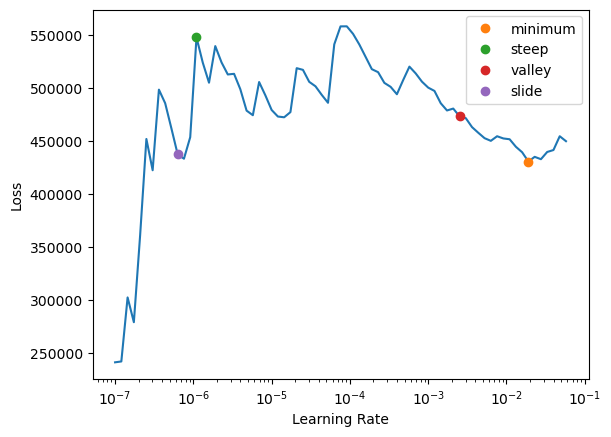

In [12]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## 5. Model Training

We now train the model using fastai’s high-level `.fit_one_cycle()` method. This schedules the learning rate for optimal convergence and monitors our metric (`rmse`) over each epoch.

In [13]:
# Train the model for 5 epochs using 1cycle learning rate policy
learn.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,_rmse,time
0,361702.906250,632565.750000,795.340149,03:57
1,445629.781250,909717.125000,953.791138,03:53
2,311884.843750,589268.812500,767.638855,03:52
3,272931.750000,2101982.500000,1449.822388,03:51
4,255106.843750,1024458.187500,1012.155212,03:54


In [14]:
learn.export('../models/block7_tabular_rossmann.pkl')

## 7. Training Results and Loss Curve

After training the model with `.fit_one_cycle()`, we plot the training and validation loss over time to evaluate performance and overfitting.

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

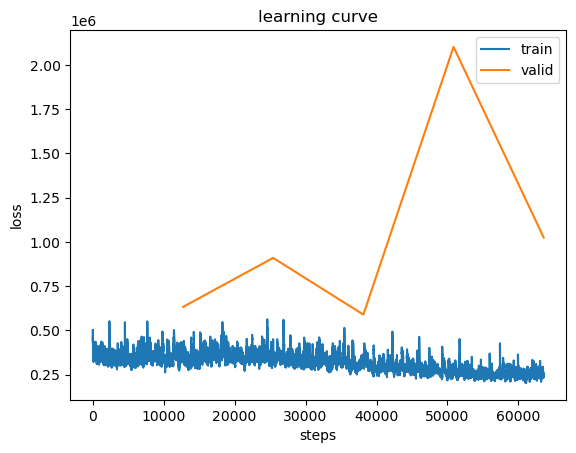

In [15]:
# Plot training and validation losses over epochs
learn.recorder.plot_loss()

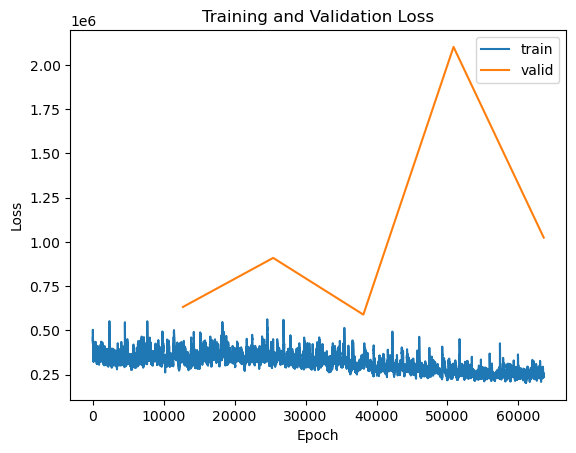

In [17]:
import matplotlib.pyplot as plt

# Plot loss
learn.recorder.plot_loss()
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Save manually
plt.savefig('../plots/loss_curve_day3.png')

## 8. Loss Curve Analysis

The plot above shows training and validation loss across batches and epochs.

### Observations:
- **Training Loss**: Decreases steadily with minor fluctuations, indicating the model is learning from the training data.
- **Validation Loss**: Spikes intermittently and is significantly higher than training loss — especially noticeable in later stages of training.

### Interpretation:
- The model fits the training data well but struggles to generalize to the validation set.
- The large gap between training and validation loss suggests **potential overfitting** or **data leakage issues** (e.g., validation set having unseen stores or promo patterns).
- It may also indicate:
  - Need for more regularization (e.g., higher dropout)
  - An imbalanced or noisy target variable (`Sales`)
  - Benefits from alternative validation strategies (e.g., time-based split)

### Next Steps:
- Consider increasing dropout or simplifying the model (fewer layers or neurons)
- Review input features for data leakage
- Experiment with more robust validation schemes (e.g., store-based splits)